In [ ]:
!pip install scipy --upgrade

In [ ]:
import os
import copy
import pickle
import zipfile
import scipy.io
import numpy as np
from tqdm.auto import tqdm
from google.colab import drive
import matplotlib.pyplot as plt

# sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# pytorch for neural network
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler

torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Thesis/WorkSpace

Mounted at /content/drive
/content/drive/MyDrive/Thesis/WorkSpace


### load the data from mat file

In [ ]:
mat = scipy.io.loadmat('Datasets/DREAMER.mat', simplify_cells=True)
data = mat['DREAMER']['Data']

### interpolate the signals to be of equal length

In [ ]:
#person1 = data[0]

inputs = []
labels = []
for person in tqdm(data):
  scores = np.swapaxes([vals for info, vals in person.items() if 'Score' in info], 0, 1)
  scores -= 1  # to start indexing from 0

  person_signals = []
  for vid in tqdm(range(18), leave=False):
    signal_vals = []
    for signal_type in ['EEG', 'ECG']:
      for signal_mode in ['baseline', 'stimuli']:
        signal = person[signal_type][signal_mode][vid]
        for channel in np.swapaxes(signal,0,1):
          ch_interp = np.interp(np.linspace(0,len(channel)-1,32768), range(len(channel)), channel)
          signal_vals.append(ch_interp)
    person_signals.append(signal_vals)
    
  inputs.extend(person_signals)
  labels.extend(scores)  


inputs = np.array(inputs)
labels = np.array(labels)
print(inputs.shape)
print(labels.shape, np.unique(labels))

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

(414, 32, 32768)
(414, 3) [0 1 2 3 4]


verify interpolated length (x axis)

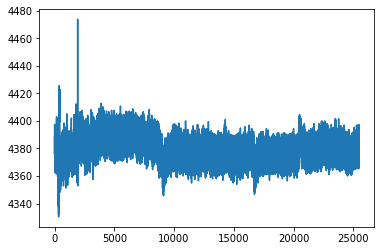

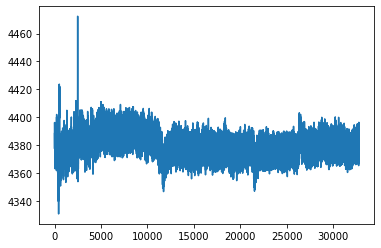

In [ ]:
plt.plot([i[0] for i in data[0]['EEG']['stimuli'][0]])
plt.show()
plt.plot(inputs[0][14])
plt.show()

### normalize the signals to be in range(-1,1)

In [ ]:
def normalize(inputs):    #channel wise normalization
  n_samples, n_channels, ch_len = inputs.shape
  for input in inputs:
    for c in range(n_channels):
      scaler = MinMaxScaler(feature_range=(-1,1)).fit(input[c].reshape(-1,1)) 
      input[c] = scaler.transform(input[c].reshape(-1,1))[:,0]

  return inputs

inputs = normalize(inputs)

verify normalized range (y axis)

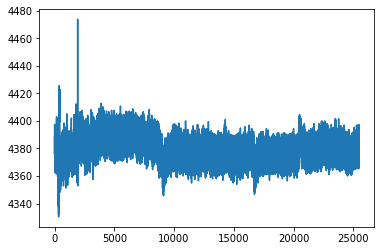

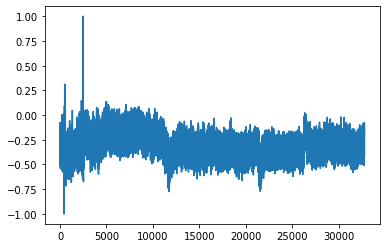

In [ ]:
plt.plot([i[0] for i in data[0]['EEG']['stimuli'][0]])
plt.show()
plt.plot(inputs[0][14])
plt.show()

### create dataloader

In [ ]:
def get_weights(target):
  class_sample_index, class_sample_count = np.unique(labels, return_counts=True)
  weight = 1. / class_sample_count
  samples_weight = np.array([weight[class_sample_index==t][0] for t in tqdm(target)])
  samples_weight = torch.from_numpy(samples_weight)
  return samples_weight


# function to create train and val loaders
def createLoaders(train_inputs, train_labels, batch_size=32, val_percent=.25):
  dataloaders = {}
  train_inputs, train_labels = map(lambda x: torch.from_numpy(x), (train_inputs, train_labels))
  if val_percent > 0:
    train_inputs, val_inputs, train_labels, val_labels = train_test_split(train_inputs, train_labels, test_size=val_percent, random_state=0)
    val_dataset = TensorDataset(val_inputs, val_labels)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    dataloaders['val'] = val_loader
  
  train_dataset = TensorDataset(train_inputs, train_labels)
  samples_weight = get_weights(train_labels.numpy())
  sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
  train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=None)
  dataloaders['train'] = train_loader

  return dataloaders

dataloaders = createLoaders(inputs, labels[:,0], batch_size=32, val_percent=0)

  0%|          | 0/414 [00:00<?, ?it/s]

### define the network

In [ ]:
class Classifier(nn.Module):

  def __init__(self, num_classes:int=2, inp_channels:int=3) -> None:
    super(Classifier, self).__init__()
    self.features = nn.Sequential(
      nn.Conv1d(inp_channels, 64, kernel_size=12, stride=4),   # np.floor((Lin + 2*padding - kernel_size)/stride + 1)
      nn.ReLU(inplace=True),
      nn.MaxPool1d(kernel_size=2, stride=4),
      nn.Conv1d(64, 192, kernel_size=4, stride=4),
      nn.ReLU(inplace=True),
      nn.MaxPool1d(kernel_size=4, stride=4),
      nn.Conv1d(192, 384, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv1d(384, 256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv1d(256, 256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool1d(kernel_size=4, stride=4),
    )
    self.avgpool = nn.AdaptiveAvgPool1d(6)
    self.classifier = nn.Sequential(
      nn.Dropout(),
      nn.Linear(256 * 6, 512),
      nn.ReLU(inplace=True),
      nn.Dropout(),
      nn.Linear(512, 128),
      nn.ReLU(inplace=True),
      nn.Linear(128, num_classes),
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

view network summary

In [ ]:
model = Classifier(num_classes=5, inp_channels=32)
model = model.to(device)

summary(model, (32,32768))
print(count_parameters(model))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 8190]          24,640
              ReLU-2             [-1, 64, 8190]               0
         MaxPool1d-3             [-1, 64, 2048]               0
            Conv1d-4             [-1, 192, 512]          49,344
              ReLU-5             [-1, 192, 512]               0
         MaxPool1d-6             [-1, 192, 128]               0
            Conv1d-7             [-1, 384, 128]         221,568
              ReLU-8             [-1, 384, 128]               0
            Conv1d-9             [-1, 256, 128]         295,168
             ReLU-10             [-1, 256, 128]               0
           Conv1d-11             [-1, 256, 128]         196,864
             ReLU-12             [-1, 256, 128]               0
        MaxPool1d-13              [-1, 256, 32]               0
AdaptiveAvgPool1d-14               [-1,

set criterion and optimizer

In [ ]:
# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### define training loop

In [ ]:
def trainNet(net,criterion,optimizer,data_loaders,epochs,check_every=None,earlyStopping=False):

  print("training network")
  train_loader = data_loaders['train']
  val_loader = data_loaders.get('val', [])
  sel = 'val' if val_loader else 'train'

  if not check_every:
      check_every = int(epochs / 10) if epochs > 10 else 1

  avg_Losses = {'train':[], 'val':[]}

  for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times

    train_loss = []
    val_loss = []

    net.train()
    for i, (inputBatch,labelBatch) in enumerate(tqdm(train_loader, leave=False, desc='train')):

        inputBatch = inputBatch.to(device).float()
        labelBatch = labelBatch.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputBatch = net(inputBatch)
        loss = criterion(outputBatch, labelBatch)
        train_loss.append(loss.item())

        # backward + optimize
        loss.backward()
        optimizer.step()
    avg_Loss = {'train' : np.mean(train_loss)}

    if val_loader:
      net.eval()
      for i, (inputBatch,labelBatch) in enumerate(tqdm(val_loader, leave=False, desc='val')):
        with torch.no_grad():

          inputBatch = inputBatch.to(device).float()
          labelBatch = labelBatch.to(device)

          # forward
          outputBatch = net(inputBatch)
          loss = criterion(outputBatch, labelBatch)
          val_loss.append(loss.item())

      avg_Loss = {'val' : np.mean(val_loss)}


    if epoch > 0:
      if avg_Loss[sel] < min(avg_Losses[sel]):
        best_params = copy.deepcopy(net.state_dict())
        best_epoch, best_loss = epoch, avg_Loss[sel]
    else:
      movAvg_old = avg_Loss[sel]

    avg_Losses['train'].append(avg_Loss['train'])
    if val_loader:
      avg_Losses['val'].append(avg_Loss['val'])

    # print statistics
    if epoch % check_every == check_every - 1:
      print('epoch: %d  | train loss: %.3f, val loss: %.3f' % (epoch + 1, avg_Loss['train'], avg_Loss.get('val',np.nan)), end="  | ")
      movAvg_new = np.mean(avg_Losses[sel][epoch+1-check_every:epoch+1])
      print('avg train loss: %.3f, avg val loss: %.3f' % (np.mean(avg_Losses['train'][epoch+1-check_every:epoch+1]), np.mean(avg_Losses['val'][epoch+1-check_every:epoch+1]) if val_loader else np.nan) )

      if earlyStopping:
        if movAvg_old < movAvg_new:
          break
        else:
          movAvg_old = movAvg_new



  print('Finished Training')
  plt.plot(avg_Losses['train'], label='train loss')
  plt.plot(avg_Losses['val'], label='val loss')
  #plt.plot([best_loss]*epoch, linestyle='dashed')
  plt.plot(best_epoch, best_loss, 'o')
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.legend()
  plt.show()

  return best_params

train the network

training network


  0%|          | 0/100 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

epoch: 10  | train loss: 1.412, val loss: nan  | avg train loss: 1.515, avg val loss: nan


train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

epoch: 20  | train loss: 1.276, val loss: nan  | avg train loss: 1.310, avg val loss: nan


train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

epoch: 30  | train loss: 0.969, val loss: nan  | avg train loss: 1.095, avg val loss: nan


train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

epoch: 40  | train loss: 0.768, val loss: nan  | avg train loss: 0.768, avg val loss: nan


train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

epoch: 50  | train loss: 0.562, val loss: nan  | avg train loss: 0.584, avg val loss: nan


train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

epoch: 60  | train loss: 0.146, val loss: nan  | avg train loss: 0.360, avg val loss: nan


train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

epoch: 70  | train loss: 0.198, val loss: nan  | avg train loss: 0.258, avg val loss: nan


train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

epoch: 80  | train loss: 0.124, val loss: nan  | avg train loss: 0.217, avg val loss: nan


train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

epoch: 90  | train loss: 0.120, val loss: nan  | avg train loss: 0.123, avg val loss: nan


train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

epoch: 100  | train loss: 0.054, val loss: nan  | avg train loss: 0.113, avg val loss: nan
Finished Training


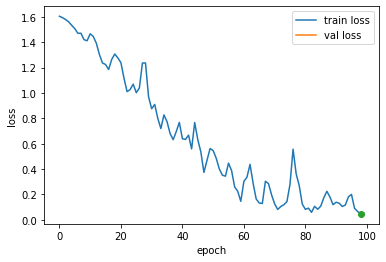

In [ ]:
model.apply(weight_reset)
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_params = trainNet(model, criterion, optimizer, dataloaders, epochs=100)

In [ ]:
model.load_state_dict(best_params)

<All keys matched successfully>

### evaluate

In [ ]:
def evaluate(net, loader):

  net.eval()
  outTrue = []
  outPred = []

  for i, (inputBatch,outTrueBatch) in enumerate(tqdm(loader)):
    with torch.no_grad():

      inputBatch = inputBatch.to(device).float()
      outTrue.extend(outTrueBatch.cpu())

      # forward
      outPredBatch = net(inputBatch).argmax(1)
      outPred.extend(outPredBatch.cpu())

  print(classification_report(outTrue, outPred, digits=4))

In [ ]:
from matplotlib.rcsetup import validate_fontsize
print("evaluation results on train data")
loader = createLoaders(inputs, labels[:,0], batch_size=32, val_percent=0)
evaluate(model, loader['train'])

evaluation results on train data


  0%|          | 0/414 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.9872    1.0000    0.9935        77
           1     0.9882    1.0000    0.9941        84
           2     1.0000    0.9889    0.9944        90
           3     0.9908    1.0000    0.9954       108
           4     1.0000    0.9636    0.9815        55

    accuracy                         0.9928       414
   macro avg     0.9932    0.9905    0.9918       414
weighted avg     0.9928    0.9928    0.9927       414

